<a href="https://colab.research.google.com/github/arpanbiswas52/paper-code-microscopyGDM/blob/main/src/GDM_SEM(Notebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Fourier-Based Global Denoising Model for Smart Artifacts Removing of Microscopy Images**
Oct, 2025

- Model developed by **Huanhuan Zhao** and **Arpan Biswas**
- Analysis by **Huanhuan Zhao** and **Arpan Biswas**
- data prepared by **Komal Sharma Agrawal**
- Project conceived by **Arpan Biswas** and **Wonhee Ko**

The notebook provides the workflow of our Global Denoising Model where we need 1-2 non-pair training images, generated from simulation or experiments or both.

- The integral architecture of the model builds on a lighweight Unet model

- The training images are prepared based on goal-specific pre-processing of raw simulated and experimental data, as per availability. The goal here is to dissolve the known artifacts and/or enhance the known features.

- The architecture has the flexibility to tune the weighting parameter which defines the percentage of information used from each image channel during training process

- Here, a FFT based loss function is also integrated with tradtional pixel based MSE loss function. Minimizing the FFT loss help to minimize the random noise and maximize the preservation of the key features.

- Here, we demonsrated the application on SSEM generated bacterial plastic consumption experimental images


In [ ]:
!pip install -q pillow tqdm matplotlib
!pip install brisque

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 5.4 MB/s eta 0:00:00
  Created wheel for libsvm-official: filename=libsvm_official-3.36.0-cp312-cp312-linux_x86_64.whl size=124634 sha256=965985e6b8757ac970b884ea56dc45f25aa423e418d715cebbee1b04a04b18c4
  Stored in directory: /root/.cache/pip/wheels/df/65/4b/c3cdece6e5fa7eebef116be2d5a309f7ac50c90183cbe12c92
Successfully built libsvm-official


In [ ]:
import os, random
from glob import glob
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from brisque import BRISQUE


from skimage import io, img_as_float
#from skimage.metrics import niqe
import glob

from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

In [ ]:
from google.colab import drive
import os
import shutil


# 1. Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Some helper function to measure image quality without reference/ground truth image

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max

def stm_fft_quality(image_input, peak_radius=10, bg_radius=30, patch_size=1, plot= False):
    # Load image in grayscale
    # Convert to grayscale NumPy array
    peak_radius = peak_radius/patch_size
    bg_radius = bg_radius/patch_size

    img_np = np.array(image_input)
    if img_np.ndim == 3:
        img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:
        img = img_np
    img = img.astype(np.float32)

    # Normalize to [0,1]
    img /= img.max()

    # Compute FFT
    fft_img = np.fft.fftshift(np.fft.fft2(img))
    magnitude_spectrum = np.abs(fft_img)

    # Compute center (DC component)
    cy, cx = magnitude_spectrum.shape[0]//2, magnitude_spectrum.shape[1]//2

    # Create mask for peaks and background
    y, x = np.ogrid[:magnitude_spectrum.shape[0], :magnitude_spectrum.shape[1]]
    r = np.sqrt((x-cx)**2 + (y-cy)**2)

    # Signal region: frequencies between peak_radius and bg_radius
    signal_mask = (r >= peak_radius) & (r <= bg_radius)
    background_mask = (r > bg_radius)

    # Compute mean intensity in signal vs background
    signal_power = magnitude_spectrum[signal_mask].mean()
    noise_power = magnitude_spectrum[background_mask].mean()

    # FFT quality score = Signal-to-Noise Ratio (SNR) in dB
    snr_db = 10 * np.log10(signal_power / noise_power)

    if plot == True:
      # Visualization
      plt.figure(figsize=(10,4))
      plt.subplot(1,2,1)
      plt.imshow(img, cmap='gray')
      plt.title('STM Image')
      plt.axis('off')

      plt.subplot(1,2,2)
      plt.imshow(np.log1p(magnitude_spectrum), cmap='inferno')
      plt.title('FFT Magnitude Spectrum')
      plt.axis('off')
      plt.show()

    return snr_db


######################################################################################


# Upgraded version
def stm_fft_peak_quality(image_input, min_distance=10, peak_prominence=0.05, patch_size=1, win= True, plot= False):
    # Load STM image in grayscale
    # Convert to grayscale NumPy array
    peak_prominence = peak_prominence/patch_size
    min_distance = min_distance/patch_size

    img_np = np.array(image_input)
    if img_np.ndim == 3:
        img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:
        img = img_np
    img = img.astype(np.float32)

    # Normalize to [0,1]
    img /= img.max()

    # Apply window to reduce edge artifacts
    if win == True:
      window = np.outer(np.hanning(img.shape[0]), np.hanning(img.shape[1]))
      img_win = img * window
    else:
      img_win = img

    # FFT and magnitude spectrum
    fft_img = np.fft.fftshift(np.fft.fft2(img_win))
    magnitude_spectrum = np.abs(fft_img)
    log_spectrum = np.log1p(magnitude_spectrum)

    # Detect peaks (exclude center DC peak)
    cy, cx = img.shape[0] // 2, img.shape[1] // 2
    coordinates = peak_local_max(
        log_spectrum,
        min_distance=int(min_distance),
        threshold_abs=int(peak_prominence * log_spectrum.max())
    )

    # Remove central DC component
    coordinates = [c for c in coordinates if np.hypot(c[0] - cy, c[1] - cx) > min_distance]

    # Compute peak power and noise floor
    peak_values = [magnitude_spectrum[y, x] for y, x in coordinates]
    if len(peak_values) == 0:
        print("No lattice peaks detected — image likely low quality.")
        return None

    peak_power = np.mean(peak_values)

    # Noise region: outside 50% of the max radius
    y, x = np.ogrid[:img.shape[0], :img.shape[1]]
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    noise_mask = r > 0.5 * r.max()
    noise_power = magnitude_spectrum[noise_mask].mean()

    # Peak-to-Noise Ratio (PNR) in dB
    pnr_db = 10 * np.log10(peak_power / noise_power)

    if plot == True:
      #Plot results
      plt.figure(figsize=(12,5))
      plt.subplot(1,2,1)
      plt.imshow(img, cmap='gray')
      plt.title("STM Image")
      plt.axis("off")

      plt.subplot(1,2,2)
      plt.imshow(log_spectrum, cmap='inferno')
      #plt.scatter([c[1] for c in coordinates], [c[0] for c in coordinates],
      #            marker='o', facecolors='none', edgecolors='cyan', s=80, label='Detected Peaks')
      plt.title("FFT Magnitude Spectrum + Peaks")
      plt.axis("off")
      plt.legend()
      plt.show()

    return pnr_db



In [ ]:
# This function measure the quality of the images via FFT peak intensity plots and the calculated Peak-to-Noise (PNR) scores (higher the better)
def showFFTScore(img,den):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img.convert("L"), cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(den, cmap="gray")
    axes[1].set_title("Denoised")
    axes[1].axis("off")

    plt.suptitle("Test Image")
    plt.tight_layout()
    plt.show()

    # Check quality -BRISQUE # lower = better
    #obj = BRISQUE(url=False)
    #print("Original image (BRISQUE):" +str(obj.score(img)))
    #print("Denoise image (BRISQUE):" +str(obj.score(den.convert("RGB"))))

    score1 = stm_fft_quality(np.array(img), plot=True)
    print(f"Basic FFT-based quality score (SNR in dB): Original image: {score1:.2f} dB") #Higher is better
    score1 = stm_fft_quality(np.array(den), plot=True)
    print(f"Basic FFT-based quality score (SNR in dB): Denoise image: {score1:.2f} dB") #Higher is better

    score2 = stm_fft_peak_quality(np.array(img), plot=True)
    if score2 is not None:
      print(f"Upgraded FFT-based quality score (SNR in dB): Original image: {score2:.2f} dB") #Higher is better
    score2 = stm_fft_peak_quality(np.array(den), plot=True)
    if score2 is not None:
      print(f"Upgraded FFT-based quality score (SNR in dB): Denoise image: {score2:.2f} dB") #Higher is better


##################################################################################################################
# This function measure the quality of the images via detected lines plots
# and the calculated total line length within the range of angle, representing the artifacts (lower the better).
from skimage import feature
from skimage.transform import probabilistic_hough_line
import numpy as np
import matplotlib.pyplot as plt

def show_detected_lines_angle_range(img,
                                    sigma=0.1,
                                    low_threshold=1,
                                    high_threshold=10,
                                    line_length=1,
                                    line_gap=2,
                                    angle_min=-50,
                                    angle_max=-35):
    """
    Detect fine lines in STM-like images, draw only lines in the specified angle range,
    return the total length of lines within that range, and show histogram of all line angles.
    """

    # if not isinstance(img, np.ndarray):
    #     img = img.detach().cpu().numpy()
    img = np.array(img)
    img = img.astype(np.float32)
    if img.max() > 1:
        img = img / 255.0

    # Edge detection
    edges = feature.canny(img, sigma=sigma,
                          low_threshold=low_threshold/255.0,
                          high_threshold=high_threshold/255.0)

    # Hough line transform
    lines = probabilistic_hough_line(edges,
                                     threshold=5,
                                     line_length=line_length,
                                     line_gap=line_gap)

    total_length_in_range = 0.0
    angles = []
    lines_in_range = []
    lengths = []

    # Filter lines by angle
    for (p0, p1) in lines:
        dx = p1[0] - p0[0]
        dy = p1[1] - p0[1]
        angle = np.degrees(np.arctan2(dy, dx))
        length = np.sqrt(dx**2 + dy**2)
        angles.append(angle)
        lengths.append(length)
        if angle_min <= angle <= angle_max:
            total_length_in_range += length
            lines_in_range.append((p0, p1))

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(18, 18))
    ax = axes.ravel()

    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(edges, cmap="gray")
    for (p0, p1) in lines_in_range:
        ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]), 'r-', linewidth=1)
    ax[1].set_title(f"Lines in [{angle_min}, {angle_max}]°\nTotal length = {total_length_in_range:.2f} px")
    ax[1].axis("off")

    ax[2].hist(angles, bins=36, range=(-90, 90), color="blue", alpha=0.7)
    ax[2].set_title("Histogram of Line Angles",fontsize=20)
    ax[2].set_xlabel("Angle (degrees)",fontsize=20)
    ax[2].set_ylabel("Count",fontsize=20)

    ax[3].hist(lengths, bins=np.arange(0, 101, 5), color="green", alpha=0.7)

    ax[3].set_title("Histogram of Line Lengths",fontsize=20)
    ax[3].set_xlabel("Line Length (pixels)",fontsize=20)
    ax[3].set_ylabel("Count",fontsize=20)
    plt.xticks(fontsize=20, fontfamily='monospace', fontstyle='italic')
    plt.yticks(fontsize=20, fontfamily='monospace', fontstyle='italic')


    plt.tight_layout()
    plt.show()

    return total_length_in_range


# FFT based loss functions

- In this paper, we have used the 2nd function

In [ ]:
# Cal fft loss for training denoise model
def fft_loss(pred, target):
    # Apply FFT
    pred_fft = torch.fft.fft2(pred)
    target_fft = torch.fft.fft2(target)

    # Shift zero frequency to center
    pred_fft = torch.fft.fftshift(pred_fft)
    target_fft = torch.fft.fftshift(target_fft)

    # Use magnitude (ignore phase)
    pred_mag = torch.abs(pred_fft)
    target_mag = torch.abs(target_fft)

    # Normalize for stability
    pred_mag = pred_mag / (pred_mag.mean() + 1e-8)
    target_mag = target_mag / (target_mag.mean() + 1e-8)

    # L1 loss in frequency domain
    return torch.mean(torch.abs(pred_mag - target_mag))

# FFT-based quality score (higher is better, normalized cross-correlation in frequency domain)
def fft_quality(pred, target):
    """
    FFT-based cosine similarity between predicted and target images.
    Returns a score in [0, 1] (higher = better).
    """
    # Compute FFT
    pred_fft = torch.fft.fft2(pred)
    target_fft = torch.fft.fft2(target)

    # Shift zero-frequency to center (for interpretability)
    pred_fft = torch.fft.fftshift(pred_fft)
    target_fft = torch.fft.fftshift(target_fft)

    # Magnitude spectra
    pred_mag = torch.abs(pred_fft).flatten()
    target_mag = torch.abs(target_fft).flatten()

    # Cosine similarity in frequency domain
    score = torch.dot(pred_mag, target_mag) / (
        pred_mag.norm() * target_mag.norm() + 1e-8
    )

    return score.item()

# Denoising model architecture and training module

In [ ]:
# -------------------- Simple U-Net model --------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base*2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = DoubleConv(base*6, base*2)
        self.dec2 = DoubleConv(base*3, base)
        self.final = nn.Conv2d(base, in_ch, kernel_size=1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d3 = self.up(e3)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up(d3)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        out = self.final(d2)
        return out

# Function to generate image patches from single training image
class STMNoiseSingleImageDataset(Dataset): #input is .png image
    def __init__(self, image_path, patch_size=128):
        if not os.path.exists(image_path):
            raise RuntimeError(f"File not found: {image_path}")
        self.img = Image.open(image_path).convert("L")
        self.patch_size = patch_size
        self.len = 1000  # number of random patches per epoch

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        w, h = self.img.size
        if w < self.patch_size or h < self.patch_size:
            self.img = self.img.resize((max(w, self.patch_size), max(h, self.patch_size)))
            w, h = self.img.size
        left = random.randint(0, w - self.patch_size)
        top = random.randint(0, h - self.patch_size)
        patch = self.img.crop((left, top, left + self.patch_size, top + self.patch_size))
        patch = np.array(patch).astype(np.float32) / 255.0
        patch = torch.from_numpy(patch).unsqueeze(0)
        return patch

# Function to create random mask on the image patches
def create_random_mask(batch, mask_fraction=0.005):
    B, C, H, W = batch.shape
    Npix = H * W
    nm = max(1, int(mask_fraction * Npix))
    masks = torch.zeros_like(batch)
    for b in range(B):
        idxs = torch.randperm(Npix)[:nm]
        ys = idxs // W
        xs = idxs % W
        masks[b, 0, ys, xs] = 1.0
    return masks

# Function to train the GDM model
def train(w1=0.5, w2=0.5, isfft=True):

    dataset1 = STMNoiseSingleImageDataset(train_image_path1, patch_size=patch_size)
    loader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    dataset2 = STMNoiseSingleImageDataset(train_image_path2, patch_size=patch_size)  ### FIXED
    loader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    model = UNetSmall(in_ch=1, base=32).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)
    mse = nn.MSELoss(reduction='none')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_fft_score = 0.0

        # zip ensures parallel iteration (stops at shortest loader)
        pbar = tqdm(zip(loader1, loader2), total=min(len(loader1), len(loader2)), desc=f"Epoch {epoch+1}/{epochs}")
        #j = 0
        for patches1, patches2 in pbar:
            #j = j+1
            # ---------------- dataset1 ----------------
            patches1 = patches1.to(device)
            masks1 = create_random_mask(patches1, mask_fraction=mask_fraction).to(device)
            inp1 = patches1.clone()
            inp1 = inp1 * (1.0 - masks1) + 0.5 * masks1
            #print(inp1.shape)
            out1 = model(inp1)
            loss_map1 = mse(out1, patches1).mean(dim=1, keepdim=True)
            pixel_loss1 = (loss_map1 * masks1).sum() / (masks1.sum() + 1e-8)
            fft_score1 = fft_quality(out1, patches1)

            # ---------------- dataset2 ----------------
            patches2 = patches2.to(device)
            masks2 = create_random_mask(patches2, mask_fraction=mask_fraction).to(device)
            inp2 = patches2.clone()
            inp2 = inp2 * (1.0 - masks2) + 0.5 * masks2
            out2 = model(inp2)
            #print(inp1.shape)
            loss_map2 = mse(out2, patches2).mean(dim=1, keepdim=True)
            pixel_loss2 = (loss_map2 * masks2).sum() / (masks2.sum() + 1e-8)
            fft_score2 = fft_quality(out2, patches2)

            # ---------------- combine ----------------
            w_pixel_loss = w1 * pixel_loss1 + w2 * pixel_loss2
            w_fft_score = w1 * fft_score1 + w2 * fft_score2

            if isfft == True:
              loss = w_pixel_loss / (1 + w_fft_score)
            else:
              loss = w_pixel_loss
              w_fft_score = 0
            #loss = w_pixel_loss / (1 + fft_score2)
            optim.zero_grad()
            loss.backward()
            optim.step()

            running_loss += loss.item()
            running_fft_score += w_fft_score
            #running_fft_score += fft_score2

            pbar.set_postfix({
                "loss": f"{running_loss:.4f}",
                "fft_score": f"{running_fft_score / (pbar.n+1):.4f}"
            })
        #print(j)
        scheduler.step()

    return model

# Function to test the GDM model- We call this once we train the GDM and want to denoise a test noisy experimental image. The code returns the denoised image
def denoise_image(model, pil_img, patch_size=128, stride=64):
    model.eval()
    img = pil_img.convert("L")
    arr = np.array(img).astype(np.float32) / 255.0
    H, W = arr.shape
    pad_h = (patch_size - (H % stride)) % stride
    pad_w = (patch_size - (W % stride)) % stride
    padded = np.pad(arr, ((0, pad_h), (0, pad_w)), mode='reflect')
    Ph, Pw = padded.shape
    out_img = np.zeros_like(padded)
    weight = np.zeros_like(padded)
    with torch.no_grad():
        for top in range(0, Ph - patch_size + 1, stride):
            for left in range(0, Pw - patch_size + 1, stride):
                patch = padded[top:top+patch_size, left:left+patch_size]
                x = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).to(device)
                pred = model(x).cpu().numpy()[0,0]
                out_img[top:top+patch_size, left:left+patch_size] += pred
                weight[top:top+patch_size, left:left+patch_size] += 1.0
    out_img = out_img / (weight + 1e-8)
    out_img = out_img[:H, :W]
    out_img = (out_img * 255.0).clip(0,255).astype(np.uint8)
    return Image.fromarray(out_img)




# Case Study 3-

- Bacterial Plastic comsumption data.
- Training with a single preprocessed experimental image

In [ ]:
# 2. Define source folder path (inside your Google Drive)
#    Example: if folder is in "MyDrive/my_project_data"
source_folder = '/content/drive/My Drive/Colab Notebooks/SEM_data'

# 3. Define destination folder path (inside Colab's working directory)
destination_folder = '/content/BacteriaPits'

# 4. Copy the folder from Drive to Colab
if os.path.exists(source_folder):
    shutil.copytree(source_folder, destination_folder)
    print(f"Folder copied to {destination_folder}")
else:
    print(f"Source folder not found: {source_folder}")

Folder copied to /content/BacteriaPits


# Image pre-processing
- Here, it is not possible to get simulated or extremely hard to get a clean image

-Thus, we use goal-specific pre-preprocessing where we locate the bright spots, masked it and inpaint with nearby pixels.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.restoration import inpaint

def remove_bright_strips(image_path, output_path="sem_cleaned.png"):
    # Load original as grayscale
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Create mask: find very bright regions (strip artifacts)
    # Adjust threshold if needed (e.g., 200 → 180 for more aggressive removal)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(img_gray, 130, 255, cv2.THRESH_BINARY)

    # Inpaint to remove the strips
    cleaned1 = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    print(img.shape)
    #cleaned2 = inpaint.inpaint_biharmonic(img, mask)

    # Save
    cv2.imwrite(output_path, cleaned1)

    # Visualization
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Detected Strips Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(cleaned1, cv2.COLOR_BGR2RGB), cmap="gray"); plt.title("Cleaned SEM Image_CV"); plt.axis("off")
    #plt.subplot(1,4,4); plt.imshow(cleaned2, cmap="gray"); plt.title("Cleaned SEM Image_Scimage"); plt.axis("off")
    plt.tight_layout()
    plt.show()

    return Image.fromarray(cleaned1)

# Example usage:
# remove_bright_strips("4807af80-54a7-4edc-a014-4deaf0fc12ea.png")

(768, 1024, 3)


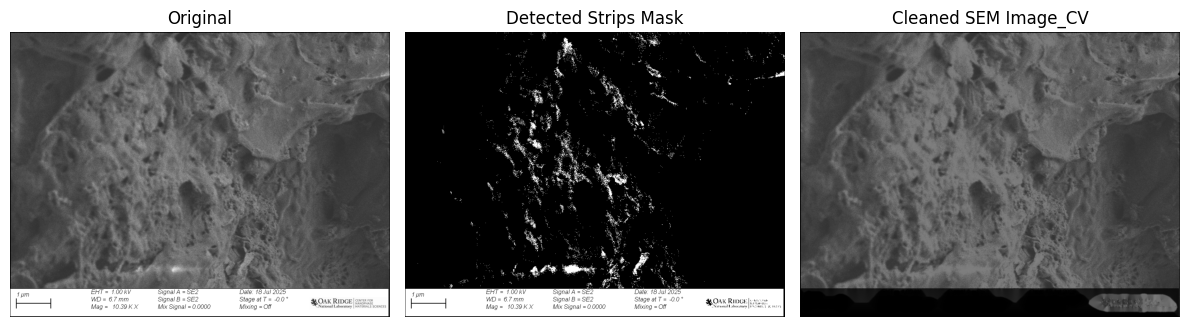

In [ ]:
train_image_path1 = "/content/BacteriaPits/pits/glyA_1.tif"
cleaned_cv= remove_bright_strips(train_image_path1, output_path="sem_cleaned_img1.png")

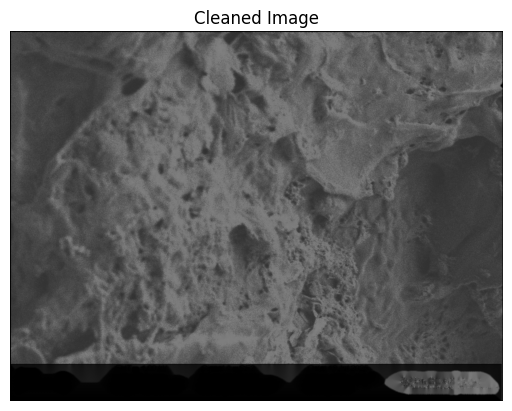

In [ ]:
# Load image
img = Image.open("sem_cleaned_img1.png")

# Show with matplotlib
plt.imshow(img, cmap="gray")
plt.axis("off")   # remove axes
plt.title("Cleaned Image")
plt.show()

Training model

In [ ]:
# -------------------- Hyperparameters --------------------

train_image_path1 = "/content/sem_cleaned_img1.png" # Noisy image
train_image_path2 = "/content/BacteriaPits/pits/glyA_5.tif" #Good quality image

patch_size = 128
batch_size = 8
epochs = 50
lr = 1e-3
mask_fraction = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#save_dir = "/content/n2v_output"
#os.makedirs(save_dir, exist_ok=True)


# ---- Run ----
model2 = train(w1=1.0, w2=0.0)




Testing model - Denoising all experimental images

In [ ]:
# Base path & filename parts

base_dir = "/content/BacteriaPits/pits/"
prefix = "glyA_"
suffix = ".tif"

# Loop through sequential file numbers
for i in range(1, 10):  # adjust 5 to your total + 1
    file_name = f"{prefix}{i:d}{suffix}"  # 1, 2, 3...
    image_path = os.path.join(base_dir, file_name)
    if os.path.exists(image_path):
            img = Image.open(image_path).convert("RGB")
            width, height = img.size
            den = denoise_image(model2, img, patch_size=min(width, height), stride=patch_size//2)
            showFFTScore(img,den)
            show_detected_lines_angle_range(img.convert("L"),  sigma=1, low_threshold=5, high_threshold=10, line_length=1, line_gap=1, angle_min=-10,  angle_max=10)
            show_detected_lines_angle_range(den.convert("L"),  sigma=1, low_threshold=5, high_threshold=10, line_length=1, line_gap=1, angle_min=-10,  angle_max=10)

Model training Without FFT loss

In [ ]:
# -------------------- Hyperparameters --------------------

train_image_path1 = "/content/sem_cleaned_img1.png" # Noisy image
train_image_path2 = "/content/BacteriaPits/pits/glyA_5.tif" #Good quality image

patch_size = 128
batch_size = 8
epochs = 50
lr = 1e-3
mask_fraction = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#save_dir = "/content/n2v_output"
#os.makedirs(save_dir, exist_ok=True)


# ---- Run ----
model2 = train(w1=1.0, w2=0.0, isfft=False)
#

In [ ]:
# Base path & filename parts

base_dir = "/content/BacteriaPits/pits/"
prefix = "glyA_"
suffix = ".tif"

# Loop through sequential file numbers
for i in range(1, 10):  # adjust 5 to your total + 1
    file_name = f"{prefix}{i:d}{suffix}"  # 1, 2, 3...
    image_path = os.path.join(base_dir, file_name)
    if os.path.exists(image_path):
            img = Image.open(image_path).convert("RGB")
            width, height = img.size
            den = denoise_image(model2, img, patch_size=min(width, height), stride=patch_size//2)
            showFFTScore(img,den)
            show_detected_lines_angle_range(img.convert("L"),  sigma=1, low_threshold=5, high_threshold=10, line_length=1, line_gap=1, angle_min=-10,  angle_max=10)
            show_detected_lines_angle_range(den.convert("L"),  sigma=1, low_threshold=5, high_threshold=10, line_length=1, line_gap=1, angle_min=-10,  angle_max=10)